# Generative Adversarial Networks

Learning objectives


1. How to define and train the standalone discriminator model for learning the difference between real and fake images.
2. How to define the standalone generator model and train the composite generator and discriminator model.
3. How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.



In [ ]:
import tensorflow as tf

from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import numpy as np
import random



In [ ]:
#### Import data from google co-lab ###
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)


Mounted at /content/gdrive


# Components of GANs
1. Generative models in the GAN architecture are required to upsample input data in order to generate an output image.                

2. The Upsampling layer is a simple layer with no weights that will double the dimensions of input and can be used in a generative model when followed by a traditional convolutional layer.           

3. The Transpose Convolutional layer is an inverse convolutional layer that will both upsample input and learn how to fill in details during the model training process.

In this lab, we have provided the example of training gan with CIFAR10 dataset.

# Exercise for GAN training

We would like to see students to use celeba-dataset that can be downloaded from the below hyperlink and try the development of GAN training.

https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

# Dataset
For convenience, we have uploaded npz file of celeba-dataset consisting of 25000 subset of cropped images on moodle. You could use the file shared in moodle and upload it to your google drive and start working on GAN training.

Original source of celeba-dataset
https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


Example of upsampling layer for a given array

In [ ]:
# example of using the upsampling layer
import numpy as np
from keras.models import Sequential
from keras.layers import UpSampling2D
# define input data
X = np.asarray([[1, 2], [3, 4]])
# show input data for context
print(X)
# reshape input data into one sample a sample with a channel
X = X.reshape((1, 2, 2, 1))
# define model
model = Sequential()
model.add(UpSampling2D(input_shape=(2, 2, 1)))
# summarize the model
model.summary()
# make a prediction with the model
yhat = model.predict(X)
# reshape output to remove channel to make printing easier
yhat = yhat.reshape((4, 4))
# summarize output
print(yhat)

# Simple generator implementation

# Literature references

Deconvolutional Networks, 2010.                   
https://ieeexplore.ieee.org/document/5539957                     
Is The Deconvolution Layer The Same As A Convolutional Layer?, 2016.           
https://arxiv.org/abs/1609.07009                            
Visualizing and Understanding Convolutional Networks, 2013.                 
https://arxiv.org/abs/1311.2901




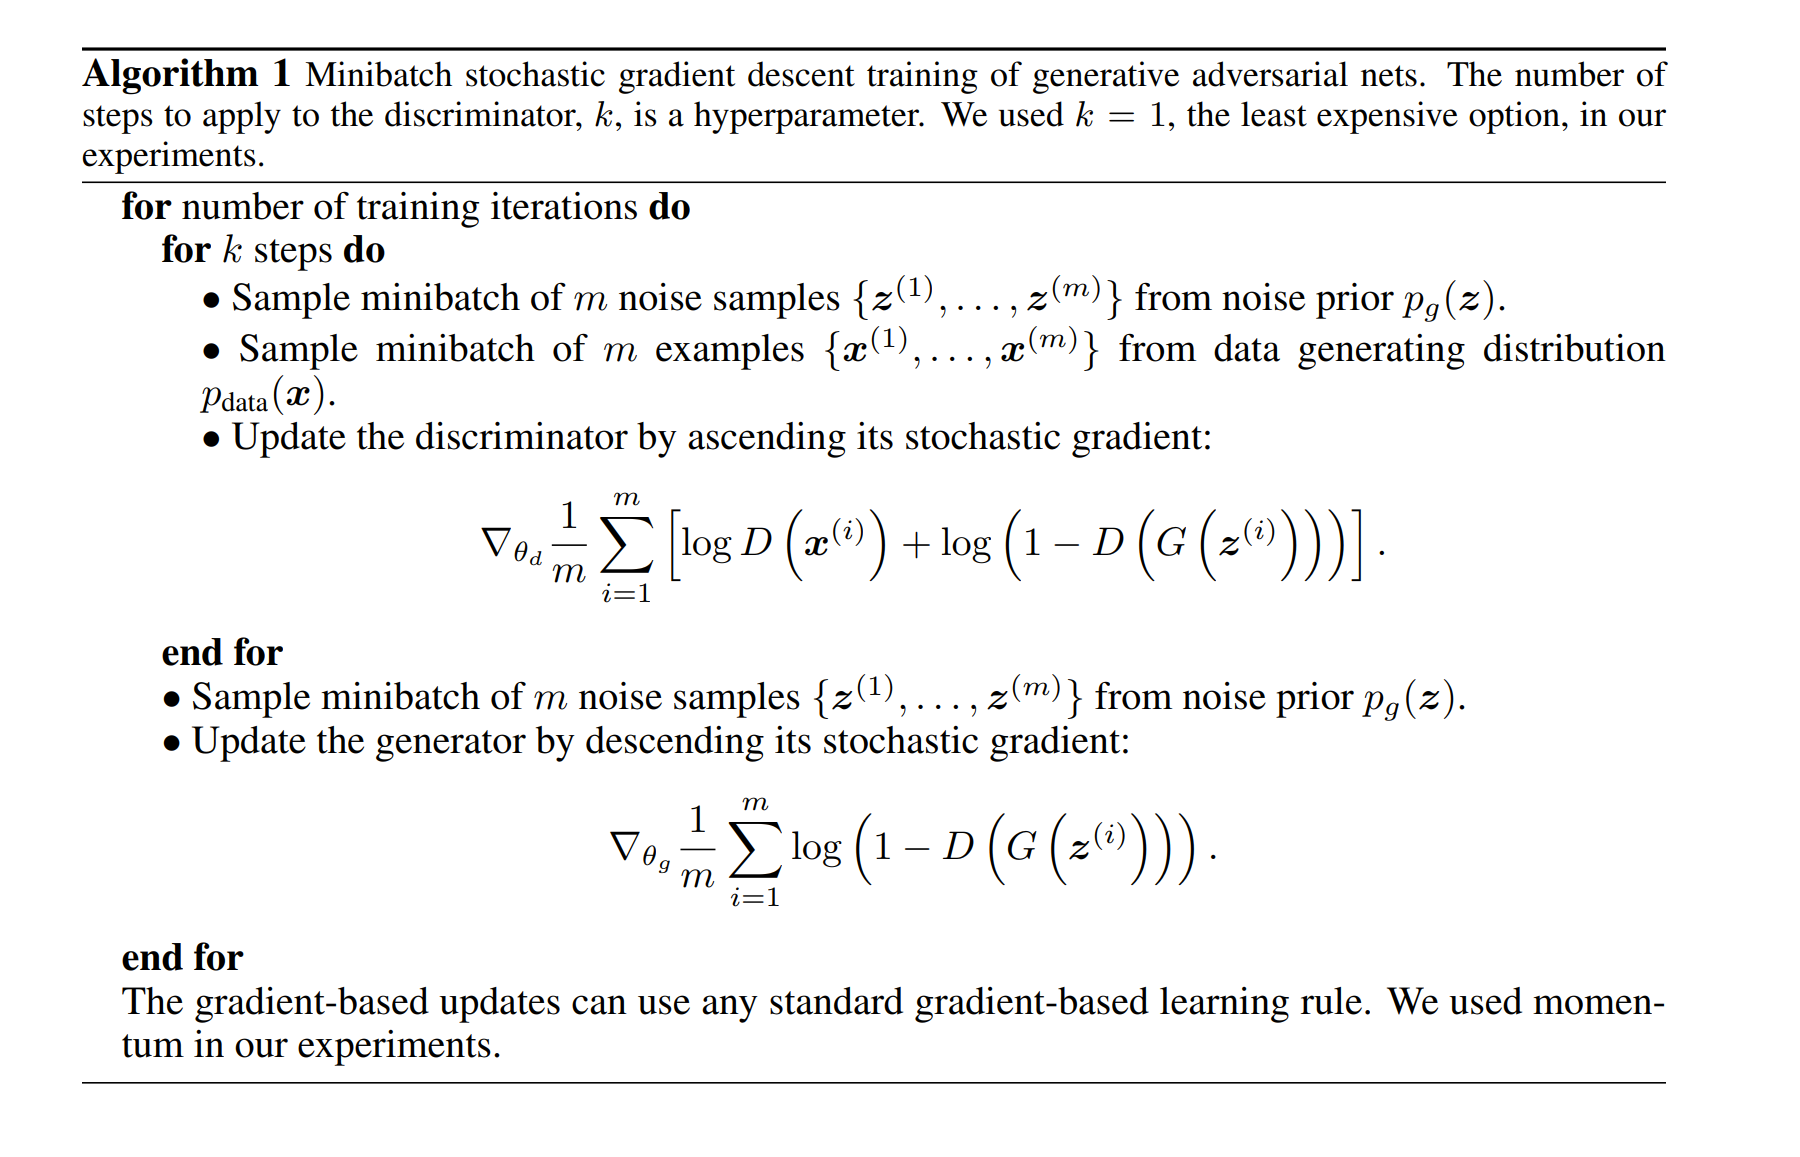


In [ ]:
# example of using upsampling in a simple generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.layers import Conv2D, Conv2DTranspose
# define model
model = Sequential()
# define input shape, output enough activations for for 128 5x5 image
model.add(Dense(128 * 5 * 5, input_dim=100))
# reshape vector of activations into 128 feature maps with 5x5
model.add(Reshape((5, 5, 128)))
# double input from 128 5x5 to 1 10x10 feature map
model.add(UpSampling2D())
# upsample to 8x8
model.add(Conv2DTranspose(32, (4, 4), strides=(1, 1), padding="same"))
model.add(LeakyReLU(alpha=0.2))
# # fill in detail in the upsampled feature maps and output a single image
model.add(Conv2D(1, (3,3), padding="same"))
# summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3200)              323200    
                                                                 
 reshape (Reshape)           (None, 5, 5, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 10, 10, 128)      0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 32)       65568     
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 10, 32)        0         
                                                                 
 conv2d (Conv2D)             (None, 10, 10, 1)         2

# Challenge of training GANs

GANs are difficult to train. The reason they are difficult to train is that both the generator model and the discriminator model are trained simultaneously in a game. This means that improvements to one model come at the expense of the other model. The goal of training two models involves finding a point of equilibrium between the two competing concerns.

This can be implemented in Keras by creating a composite model that combines the generator and discriminator models, allowing the output images from the generator to flow into discriminator directly, and in turn, allow the error signals from the predicted probabilities of
the discriminator to flow back through the weights of the generator model. 

In [ ]:
# define the standalone discriminator model
# Finds real or fake so its a binary classification
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding="same", input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model


# define the standalone generator model
#  Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
#  Outputs: Two-dimensional square color image (3 channels) of 32 × 32 pixels with pixel
#  values in [-1, 1]
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3, 3), activation="tanh", padding="same"))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, trainY), (testX, testY) = load_data()
  tr_samps = len(range(0, 20000))
  ts_samps = len(range(0, 4000))
  print(tr_samps)
  print(ts_samps)
  trainX, trainY = shuffle(trainX, trainY, random_state=2)
  testX, testY = shuffle(testX, testY, random_state=26)

  trainX, trainY = trainX[0:tr_samps, :, :, :], trainY[0:tr_samps, :]
  testX, testY = testX[0:ts_samps, :, :, :], testY[0:ts_samps, :]

  X = trainX
  # convert from unsigned ints to floats
  X = X.astype("float32")
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X


# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create fake class labels (0)
  y = np.zeros((n_samples, 1))
  return X, y


# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis("off")
    # plot raw pixel data
    plt.imshow(examples[i])
    # save plot to file
  filename = r"/content/gdrive/MyDrive/Colab Notebooks/generated_plot_v1_e%03d.png" % (epoch+1)
  plt.savefig(filename)
  plt.close()




In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print("Epoch>%d -> Accuracy real: %.0f%%, fake: %.0f%%" % (epoch, acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = r"/content/gdrive/MyDrive/Colab Notebooks/generator_model_v1_%03d.h5" % (epoch+1)
  g_model.save(filename)



In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      # Fake samples generated by generator is fed to the discriminator
      # with inverted labels 
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print("Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f" %
          (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)
